# Install Apache Solr

In [ ]:
# Download the binary solr file from the apache.org
!wget -O solr-9.6.0.tgz https://www.apache.org/dyn/closer.lua/solr/solr/9.6.0/solr-9.6.0.tgz?action=download

--2024-05-22 11:42:33--  https://www.apache.org/dyn/closer.lua/solr/solr/9.6.0/solr-9.6.0.tgz?action=download
Resolving www.apache.org (www.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to www.apache.org (www.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dlcdn.apache.org/solr/solr/9.6.0/solr-9.6.0.tgz [following]
--2024-05-22 11:42:33--  https://dlcdn.apache.org/solr/solr/9.6.0/solr-9.6.0.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282419640 (269M) [application/x-gzip]
Saving to: ‘solr-9.6.0.tgz’

solr-9.6.0.tgz      100%[===================>] 269.34M   240MB/s    in 1.1s    

2024-05-22 11:42:34 (240 MB/s) - ‘solr-9.6.0.tgz’ saved [282419640/282419640]



In [ ]:
# Extract the binary solr files
!tar -xzf solr-9.6.0.tgz

# Check processes

In [ ]:
!lsof -iTCP -sTCP:LISTEN

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
node        7 root   21u  IPv6  19678      0t0  TCP *:8080 (LISTEN)
kernel_ma  20 root    3u  IPv4  19499      0t0  TCP e3e137fc3e90:6000 (LISTEN)
colab-fil  58 root    3u  IPv4  19019      0t0  TCP localhost:3453 (LISTEN)
jupyter-n 104 root    7u  IPv4  19189      0t0  TCP e3e137fc3e90:9000 (LISTEN)
python3   757 root   21u  IPv4  38769      0t0  TCP localhost:35361 (LISTEN)
python3   792 root    3u  IPv4  40825      0t0  TCP localhost:40233 (LISTEN)
python3   792 root    5u  IPv4  40826      0t0  TCP localhost:45221 (LISTEN)


# Acess the Solr Admin UI

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.511s


In [ ]:
get_ipython().system_raw('lt --port 8983 --subdomain ipysolr >> url.txt 2>&1 &')

In [ ]:
!cat url.txt

your url is: https://jolly-vampirebat-88.loca.lt


In [ ]:
import requests

def get_public_ip():
    response = requests.get('https://ipinfo.io/ip')
    if response.status_code == 200:
        return response.text.strip()
    else:
        return None

public_ip = get_public_ip()
print(f"Public IP: {public_ip}")


Public IP: 34.125.250.86


# Example 1

## Launch Solr

In [ ]:
!cd solr-9.6.0/ && bin/solr start -c -force

/bin/bash: line 1: cd: solr-9.6.0/: No such file or directory


## Optional: Solr cluster mode
To start another Solr node and have it join the cluster alongside the first node

In [ ]:
!cd solr-9.6.0/ && bin/solr -c -z localhost:9983 -p 8984 -force

Waiting up to 180 seconds to see Solr running on port 8984 [|]   [/]   [-]   [\]   [|]   [/]  
Started Solr server on port 8984 (pid=1777). Happy searching!

    

## Create a collection

In [ ]:
%%shell
curl --request POST \
--url http://localhost:8983/api/collections \
--header 'Content-Type: application/json' \
--data '{
  "create": {
    "name": "techproducts",
    "numShards": 1,
    "replicationFactor": 1
  }
}'

{"responseHeader":{"status":500,"QTime":548},"error":{"msg":"Unrecognized field \"create\" (class org.apache.solr.client.api.model.CreateCollectionRequestBody), not marked as ignorable (17 known properties: \"pullReplicas\", \"config\", \"router\", \"shardNames\", \"name\", \"waitForFinalState\", \"alias\", \"properties\", \"perReplicaState\", \"createReplicas\", \"shuffleNodes\", \"replicationFactor\", \"async\", \"nodeSet\", \"tlogReplicas\", \"numShards\", \"nrtReplicas\"])\n at [Source: REDACTED (`StreamReadFeature.INCLUDE_SOURCE_IN_LOCATION` disabled); line: 2, column: 14] (through reference chain: org.apache.solr.client.api.model.CreateCollectionRequestBody[\"create\"])","trace":"com.fasterxml.jackson.databind.exc.UnrecognizedPropertyException: Unrecognized field \"create\" (class org.apache.solr.client.api.model.CreateCollectionRequestBody), not marked as ignorable (17 known properties: \"pullReplicas\", \"config\", \"router\", \"shardNames\", \"name\", \"waitForFinalState\", \"

## Define a schema

Define the fields that our documents will contain.


https://solr.apache.org/guide/solr/latest/indexing-guide/field-type-definitions-and-properties.html#field-default-properties

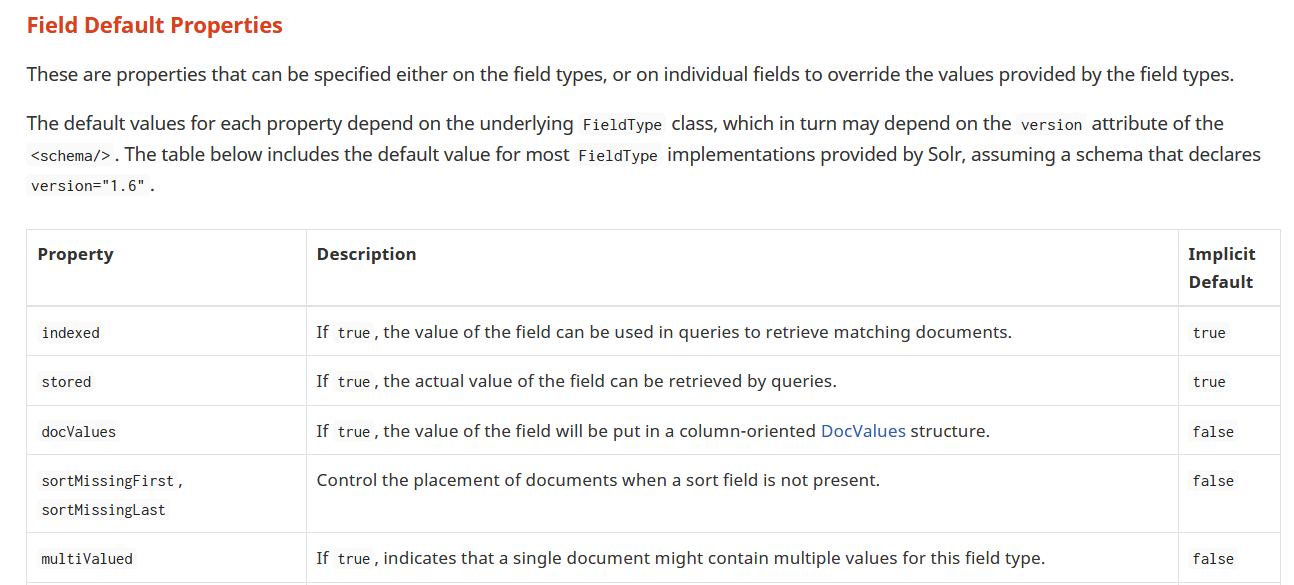

In [ ]:
%%shell
curl --request POST \
  --url http://localhost:8983/api/collections/techproducts/schema \
  --header 'Content-Type: application/json' \
  --data '{
  "add-field": [
    {"name": "name", "type": "text_general", "multiValued": false},
    {"name": "cat", "type": "string", "multiValued": true},
    {"name": "manu", "type": "string"},
    {"name": "features", "type": "text_general", "multiValued": true},
    {"name": "weight", "type": "pfloat"},
    {"name": "price", "type": "pfloat"},
    {"name": "popularity", "type": "pint"},
    {"name": "inStock", "type": "boolean", "stored": true},
    {"name": "store", "type": "location"}
  ]
}'

{
  "responseHeader":{
    "status":0,
    "QTime":1395}}


In [ ]:
# Check newly created fields
!curl --request GET --url http://localhost:8983/api/collections/techproducts/schema/fields

## Index a single document

In [ ]:
%%shell
curl --request POST \
--url 'http://localhost:8983/api/collections/techproducts/update' \
  --header 'Content-Type: application/json' \
  --data '  {
    "id" : "978-0641723445",
    "cat" : ["book","hardcover"],
    "name" : "The Lightning Thief",
    "author" : "Rick Riordan",
    "series_t" : "Percy Jackson and the Olympians",
    "sequence_i" : 1,
    "genre_s" : "fantasy",
    "inStock" : true,
    "price" : 12.50,
    "pages_i" : 384
  }'

{
  "responseHeader":{
    "rf":1,
    "status":0,
    "QTime":348}}


## Index multiple documents

In [ ]:
%%shell
curl --request POST \
  --url 'http://localhost:8983/api/collections/techproducts/update' \
  --header 'Content-Type: application/json' \
  --data '  [
  {
    "id" : "978-0641723445",
    "cat" : ["book","hardcover"],
    "name" : "The Lightning Thief",
    "author" : "Rick Riordan",
    "series_t" : "Percy Jackson and the Olympians",
    "sequence_i" : 1,
    "genre_s" : "fantasy",
    "inStock" : true,
    "price" : 12.50,
    "pages_i" : 384
  }
,
  {
    "id" : "978-1423103349",
    "cat" : ["book","paperback"],
    "name" : "The Sea of Monsters",
    "author" : "Rick Riordan",
    "series_t" : "Percy Jackson and the Olympians",
    "sequence_i" : 2,
    "genre_s" : "fantasy",
    "inStock" : true,
    "price" : 6.49,
    "pages_i" : 304
  }
]'

{
  "responseHeader":{
    "rf":1,
    "status":0,
    "QTime":16}}


## Commit the changes
After documents are indexed into a collection, they are not immediately available for searching. In order to have them searchable, a commit operation (also called refresh in other search engines like OpenSearch etc.) is needed. Commits can be scheduled at periodic intervals using auto-commits as follows.

In [ ]:
%%shell
curl -X POST -H 'Content-type: application/json' \
--URL http://localhost:8983/api/collections/techproducts/config \
--data '{"set-property":{"updateHandler.autoCommit.maxTime":3000}}'

{
  "responseHeader":{
    "status":0,
    "QTime":383},
  "WARNING":"This response format is experimental.  It is likely to change in the future."}


## Make a search

https://solr.apache.org/guide/solr/latest/query-guide/standard-query-parser.html

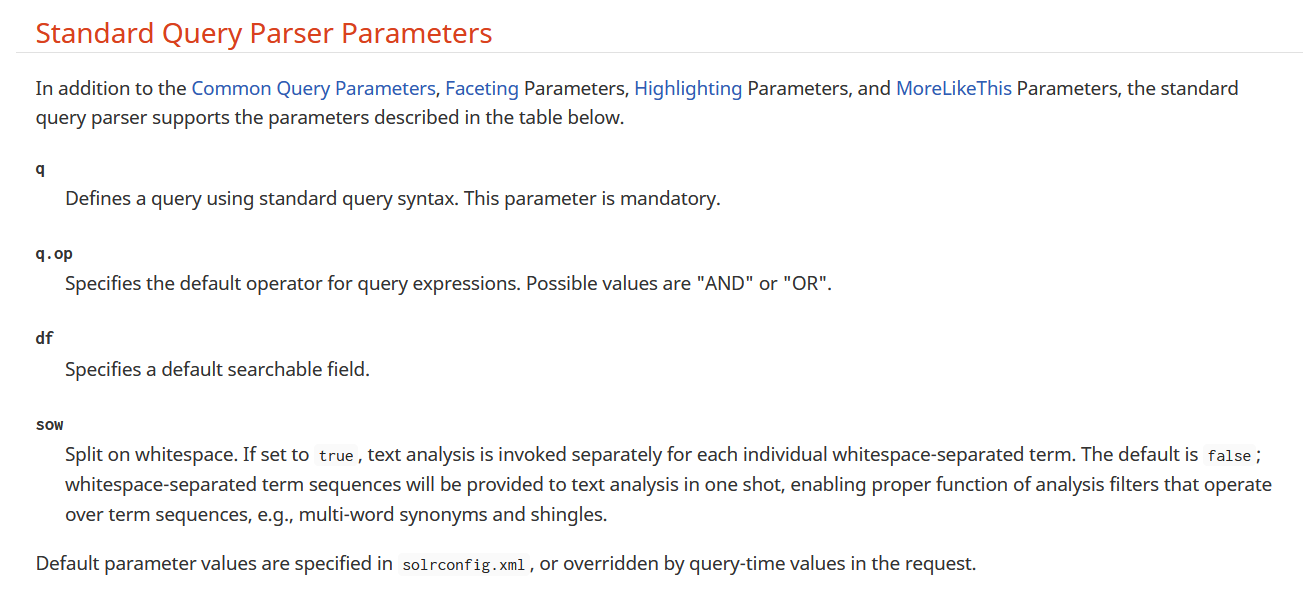

In [ ]:
!curl 'http://localhost:8983/solr/techproducts/select?q=lightning&df=name'

{
  "responseHeader":{
    "zkConnected":true,
    "status":0,
    "QTime":60,
    "params":{
      "q":"lightning",
      "df":"name"}},
  "response":{"numFound":1,"start":0,"numFoundExact":true,"docs":[
      {
        "id":"978-0641723445",
        "cat":["book",
          "hardcover"],
        "name":"The Lightning Thief",
        "author":["Rick Riordan"],
        "series_t":"Percy Jackson and the Olympians",
        "sequence_i":1,
        "genre_s":"fantasy",
        "inStock":true,
        "price":12.5,
        "pages_i":384,
        "_version_":1767318510434779136}]
  }}


## Delete collection

In [ ]:
!cd solr-9.2.1/ && bin/solr delete -c techproducts

WARN  - 2023-05-30 11:35:54.017; org.apache.solr.common.cloud.SolrZkClient; Using default ZkCredentialsInjector. ZkCredentialsInjector is not secure, it creates an empty list of credentials which leads to 'OPEN_ACL_UNSAFE' ACLs to Zookeeper nodes
WARN  - 2023-05-30 11:35:54.143; org.apache.solr.common.cloud.SolrZkClient; Using default ZkACLProvider. DefaultZkACLProvider is not secure, it creates 'OPEN_ACL_UNSAFE' ACLs to Zookeeper nodes
{
  "responseHeader":{
    "status":0,
    "QTime":600},
  "success":{"localhost:8983_solr":{"responseHeader":{
        "status":0,
        "QTime":182}}}}


Deleted collection 'techproducts' using command:
http://localhost:8983/solr/admin/collections?action=DELETE&name=techproducts


## Stop solr instances

In [ ]:
!cd solr-9.2.1/ && bin/solr stop -all

Sending stop command to Solr running on port 8983 ... waiting up to 180 seconds to allow Jetty process 2070 to stop gracefully.
 [|]   [/]   [-]   [\]   [|]      